The purpose of this notebook is to demonstrate how to refine with locally defined GSAS-II functions.



# Imports

In [1]:
# general libraties that exist on most systems

import os
import importlib
import sys
import time
import shutil
from IPython.display import clear_output


# The libraries that we will need in this notebook.
# If the required library doesn't exist, we install it via pip

required_packages   = {'numpy','xarray','ipympl','pymatgen','pybaselines','h5netcdf'}

for rp in required_packages:
    try:
        print('Checking %s package'%rp)
        globals()[rp] = importlib.import_module(rp)
    except:
        print('Installing %s'%rp)
        !! pip install $rp
        globals()[rp] = importlib.import_module(rp)
        if rp == 'pymatgen':
            !reset -f


import numpy as np
import xarray as xr



# importing matplotlib for plots.
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

Checking pybaselines package
Checking xarray package
Checking ipympl package
Checking numpy package
Checking pymatgen package
Checking h5netcdf package


# mxrd class

In [2]:
%run -i mxrd.py

In [3]:
sample_Kapton = exrd()
sample_Kapton.read_data(nc_file='integrated/Kapton.nc',plot=False)
sample_Air = exrd()
sample_Air.read_data(nc_file='integrated/Air_scattering.nc',plot=False)

GSAS-II binary directory: /home/mt/g2full/GSAS-II/GSASII-bin/linux_64_p3.11_n1.26
7 values read from config file /home/mt/g2full/GSAS-II/GSASII/config.py

Rwp from 1st refinement is = 5.851 
 

Background is refined. Rwp is now 5.748 (was 5.851)

Instrument parameters ['U'] are refined. Rwp is now 5.747 (was 5.748)

Instrument parameters ['V'] are refined. Rwp is now 5.747 (was 5.747)

Instrument parameters ['W'] are refined. Rwp is now 5.747 (was 5.747)

Instrument parameters ['Y'] are refined. Rwp is now 5.753 (was 5.747)

Instrument parameters ['Zero'] are refined. Rwp is now 5.752 (was 5.753)

Background is refined. Rwp is now 5.752 (was 5.752)

Instrument parameters ['U', 'V', 'W', 'Y', 'Zero'] are refined. Rwp is now 5.760 (was 5.752)

Background is refined. Rwp is now 5.759 (was 5.760)

Instrument parameters ['U'] are refined. Rwp is now 5.759 (was 5.759)

Instrument parameters ['V'] are refined. Rwp is now 5.759 (was 5.759)

Instrument parameters ['W'] are refined. Rwp is now 5

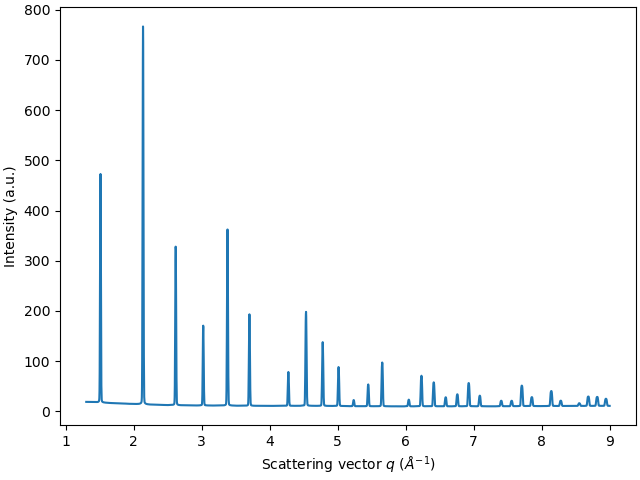

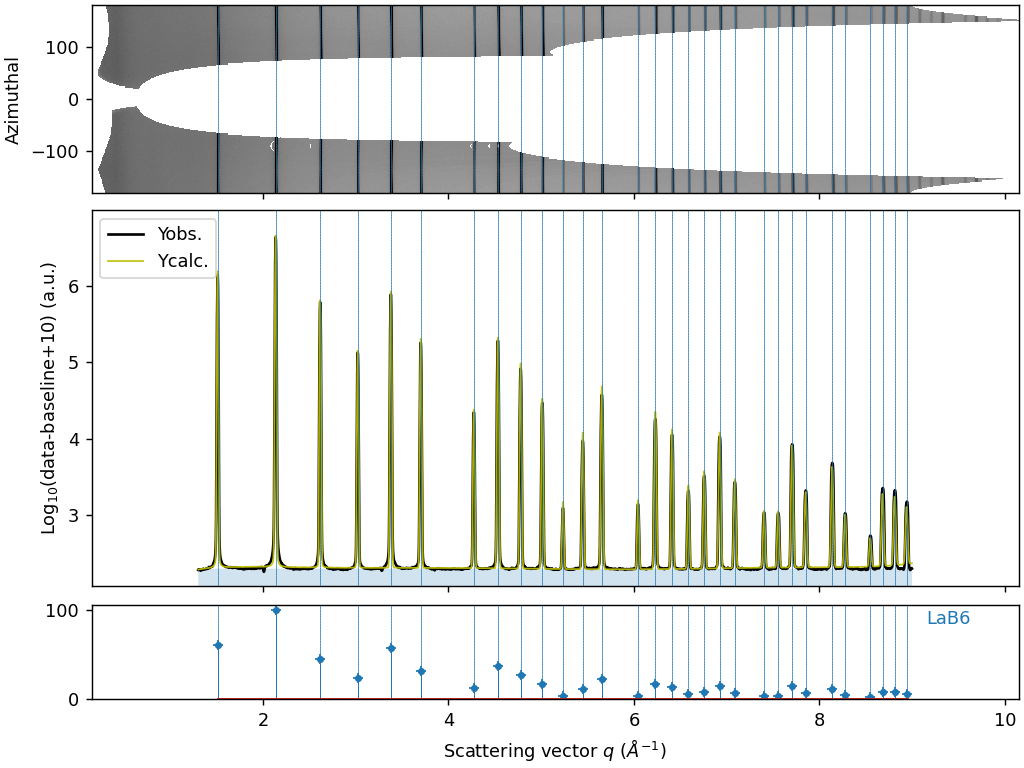

In [5]:
phases = [
        {"mp_id":'none', "cif":'_cifs/LaB6_a=4.1568_NIST_value.cif', "label":"LaB6", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        ]
sample = exrd(verbose=False)
sample.read_data(nc_file='integrated/NIST-LaB6.nc',
                 radial_range=(1.3,9),
                #  azimuthal_range=[-180,-150]
                 )
sample.get_baseline(i1d_bkg=sample_Kapton.ds.i1d,arpls_lam=1e7,plot=False,use_arpls=True)
sample.load_phases(phases=phases,plot=False)


sample.setup_gsas2_calculator(instprm_from_gpx='/users/mt/OneDrive/repositories/easyXRD/examples/data/gsas_LaB6.gpx')
# sample.set_LeBail()

sample.refine_background()

for par in ['U', 'V', 'W', 'Y', 'Zero']:
    sample.refine_inst_parameters(inst_pars_to_refine=[par])
sample.refine_background()

sample.refine_inst_parameters(inst_pars_to_refine=['U', 'V', 'W', 'Y', 'Zero'])
sample.refine_background()


for par in ['U', 'V', 'W', 'Y', 'Zero']:
    sample.refine_inst_parameters(inst_pars_to_refine=[par])
sample.refine_background()

sample.refine_inst_parameters(inst_pars_to_refine=['U', 'V', 'W', 'Y', 'Zero'])
sample.refine_background()

for par in ['U', 'V', 'W', 'Y', 'Zero']:
    sample.refine_inst_parameters(inst_pars_to_refine=[par])
sample.refine_background()

sample.refine_inst_parameters(inst_pars_to_refine=['U', 'V', 'W', 'Y', 'Zero'])
sample.refine_background()


for par in ['U', 'V', 'W', 'Y', 'Zero']:
    sample.refine_inst_parameters(inst_pars_to_refine=[par])
sample.refine_background()

sample.refine_inst_parameters(inst_pars_to_refine=['U', 'V', 'W', 'Y', 'Zero'])
sample.refine_background()


sample.gpx_plotter()


Rwp from 1st refinement is = 10.321 
 

Background is refined. Rwp is now 10.172 (was 10.321)

Size broadening of all phases are refined. Rwp is now 9.883 (was 10.172)

Strain broadening of all phases are refined. Rwp is now 9.957 (was 9.883)


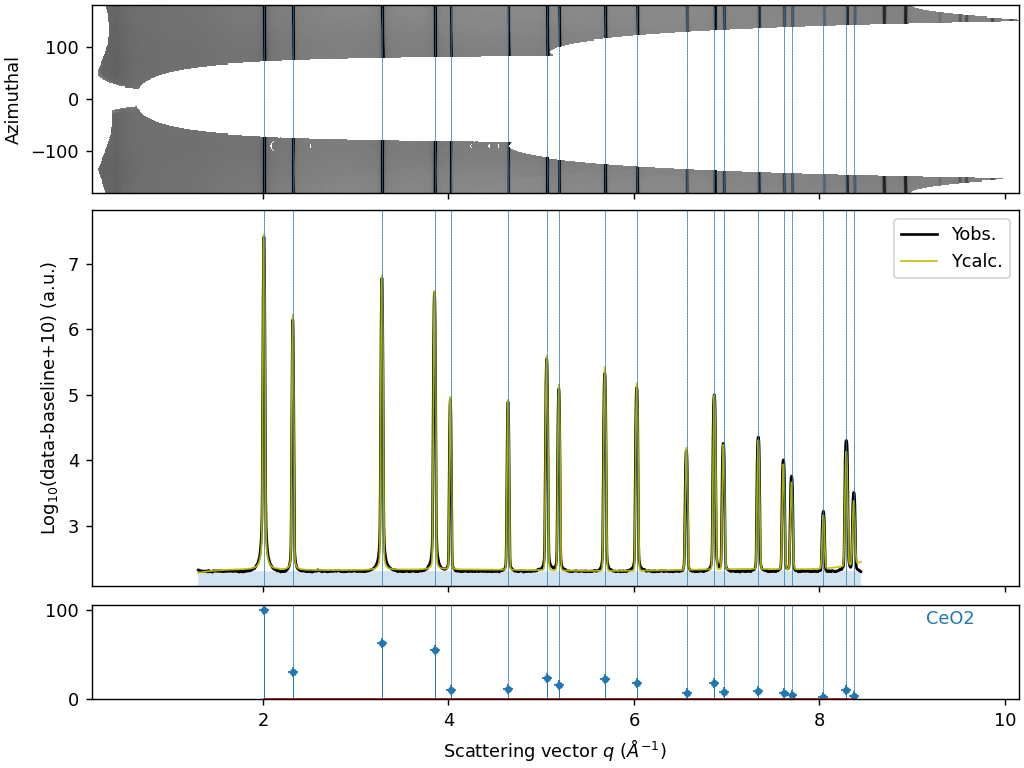

In [6]:
phases = [
        {"mp_id":'none', "cif":'_cifs/CeO2_a=5.4113_NIST_value.cif', "label":"CeO2", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        ]
sample = exrd(verbose=False)
sample.read_data(nc_file='integrated/NIST-CeO2.nc',
                 plot=False,
                 radial_range=(1.3,8.45),
                 )
sample.get_baseline(i1d_bkg=sample_Kapton.ds.i1d,arpls_lam=1e5,plot=False,use_arpls=True)
sample.load_phases(phases=phases,plot=False)


sample.setup_gsas2_calculator(instprm_from_gpx='/users/mt/OneDrive/repositories/easyXRD/examples/data/gsas_LaB6.gpx')
# sample.set_LeBail()



sample.refine_background()
sample.refine_size_broadening()
sample.refine_strain_broadening()


sample.gpx_plotter()


Rwp from 1st refinement is = 10.406 
 

Background is refined. Rwp is now 10.363 (was 10.406)


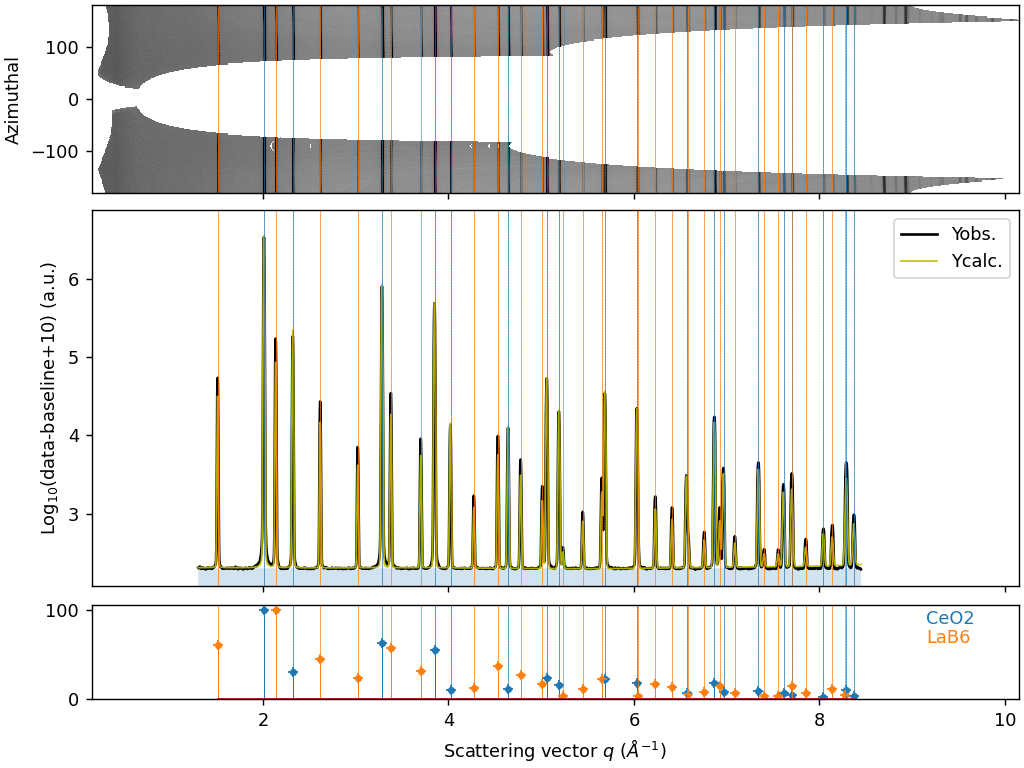

In [7]:
phases = [
        {"mp_id":'none', "cif":'_cifs/CeO2_a=5.4113_NIST_value.cif', "label":"CeO2", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        {"mp_id":'none', "cif":'_cifs/LaB6_a=4.1568_NIST_value.cif', "label":"LaB6", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        ]
sample = exrd(verbose=False)
sample.read_data(nc_file='integrated/NIST-LaB6-CeO2-mix.nc',
                 plot=False,
                 radial_range=(1.3,8.45),
                 )
sample.get_baseline(i1d_bkg=sample_Kapton.ds.i1d,arpls_lam=1e5,plot=False,use_arpls=True)
sample.load_phases(phases=phases,plot=False)


sample.setup_gsas2_calculator(instprm_from_gpx='/users/mt/OneDrive/repositories/easyXRD/examples/data/gsas_LaB6.gpx')
# sample.set_LeBail()



sample.refine_background()




sample.gpx_plotter()


Rwp from 1st refinement is = 14.947 
 

Background is refined. Rwp is now 14.862 (was 14.947)


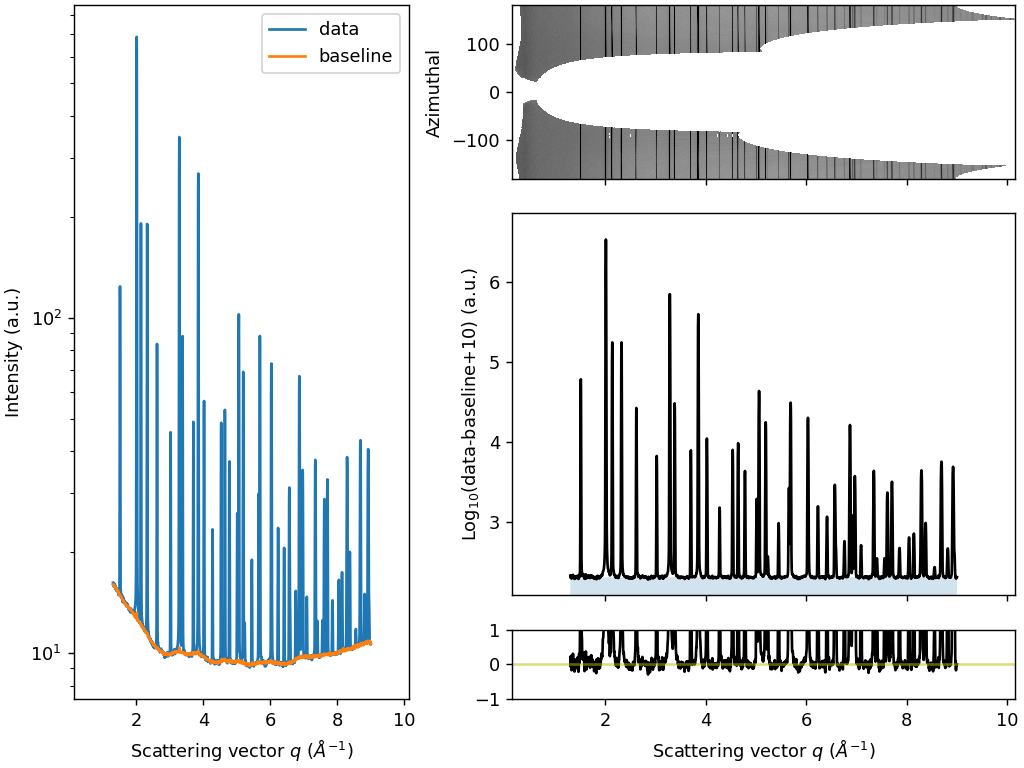

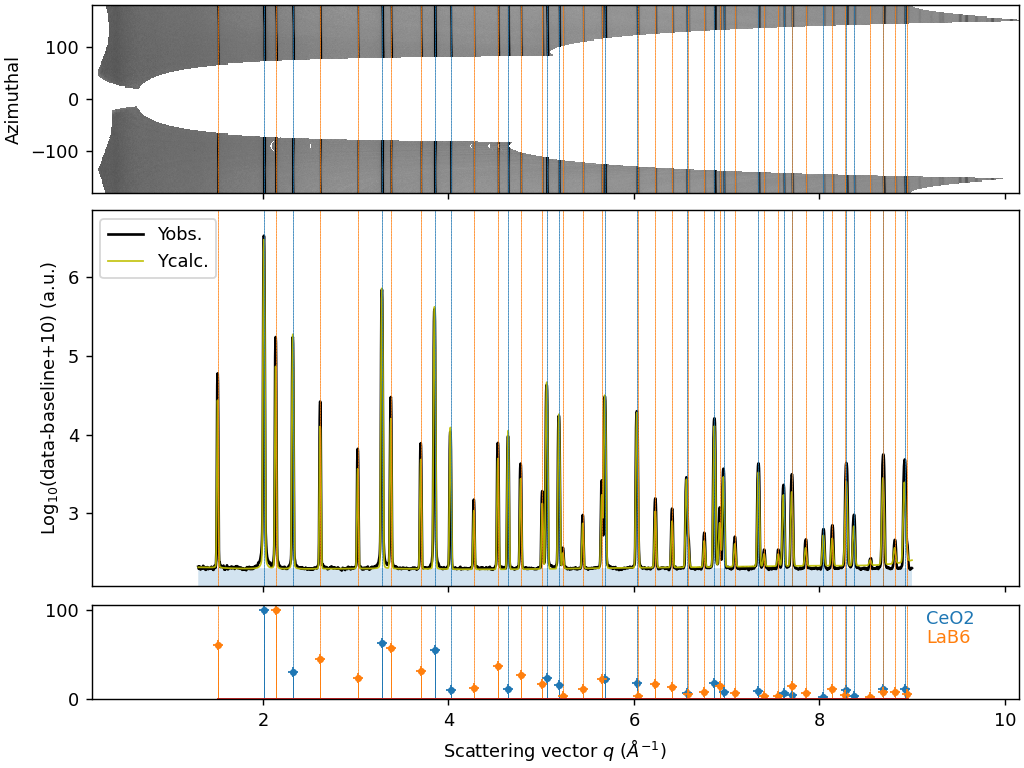

In [8]:
phases = [
        {"mp_id":'none', "cif":'_cifs/CeO2_a=5.4113_NIST_value.cif', "label":"CeO2", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        {"mp_id":'none', "cif":'_cifs/LaB6_a=4.1568_NIST_value.cif', "label":"LaB6", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        ]
sample = exrd(verbose=False)
sample.read_data(nc_file='integrated/NIST-LaB6-CeO2-mix.nc',
                 plot=False,
                 radial_range=(1.3,9),
                 azimuthal_range=[150,180]
                 )
sample.get_baseline(i1d_bkg=sample_Kapton.ds.i1d,arpls_lam=1e6,plot=True)
sample.load_phases(phases=phases,plot=False)


sample.setup_gsas2_calculator(instprm_from_gpx='/users/mt/OneDrive/repositories/easyXRD/examples/data/gsas_LaB6.gpx')
# sample.set_LeBail()



sample.refine_background()




sample.gpx_plotter()

i1d_bkg is not provided. Using arpls to find the baseline



Rwp from 1st refinement is = 14.923 
 

Background is refined. Rwp is now 14.840 (was 14.923)


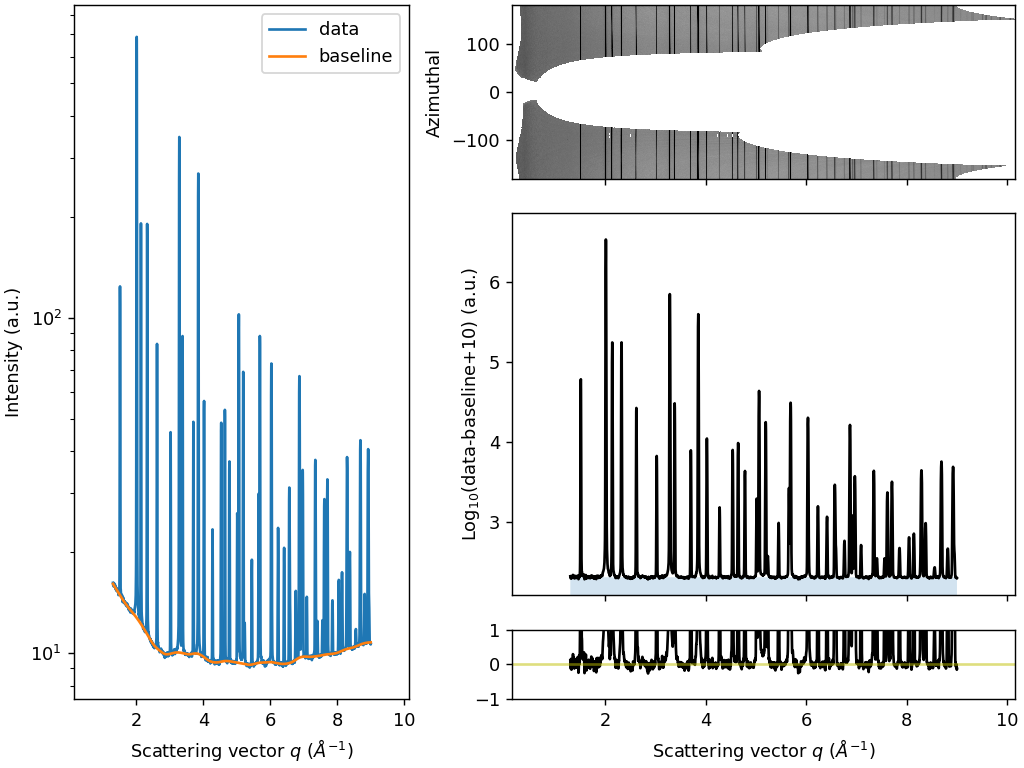

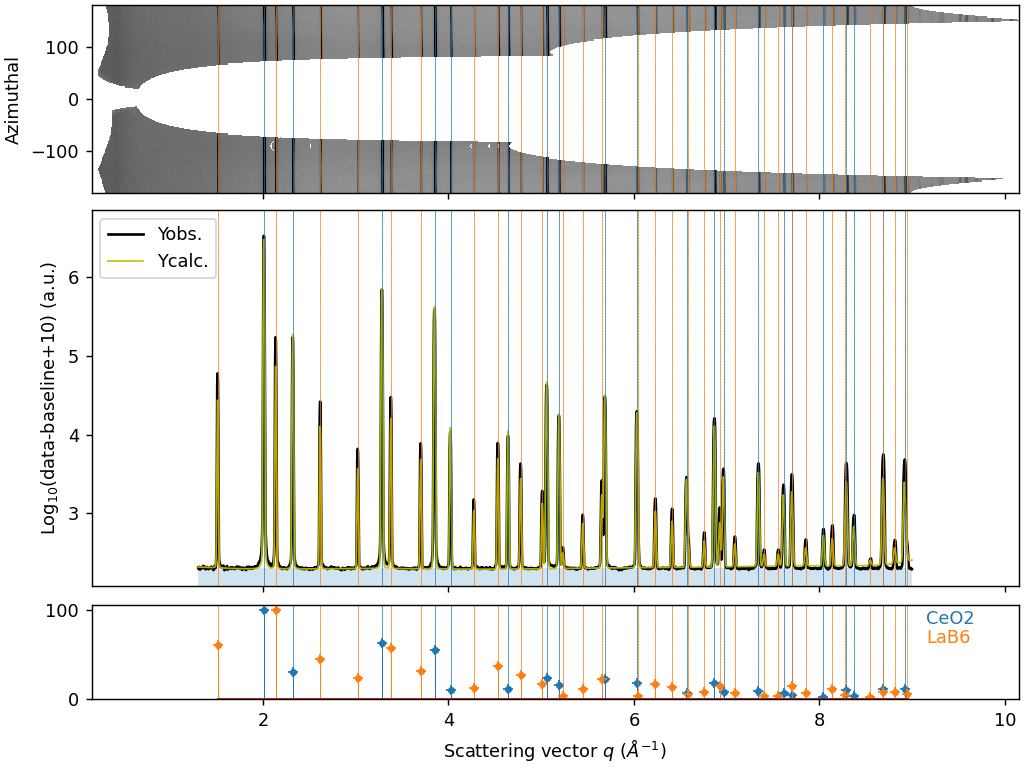

In [9]:
phases = [
        {"mp_id":'none', "cif":'_cifs/CeO2_a=5.4113_NIST_value.cif', "label":"CeO2", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        {"mp_id":'none', "cif":'_cifs/LaB6_a=4.1568_NIST_value.cif', "label":"LaB6", "scale":1, "scale_a":1, "scale_b":1, "scale_c":1},
        ]
sample = exrd(verbose=False)
sample.read_data(nc_file='integrated/NIST-LaB6-CeO2-mix.nc',
                 plot=False,
                 radial_range=(1.3,9),
                 azimuthal_range=[150,180]
                 )
sample.get_baseline(i1d_bkg=None,arpls_lam=1e6,plot=True)
sample.load_phases(phases=phases,plot=False)


sample.setup_gsas2_calculator(instprm_from_gpx='/users/mt/OneDrive/repositories/easyXRD/examples/data/gsas_LaB6.gpx')
# sample.set_LeBail()



sample.refine_background()




sample.gpx_plotter()